# Multilabel classification for amorphous silicon - accuracy separated for different structure sizes (64, 216, 512, 1024)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from torch.utils.data import DataLoader, TensorDataset
from steinhardt import get_steinhardt_params

## Data pre-processing

### Get dataset with atomic coordinates and turn it into a dataset with Stenhard OPs

In [2]:
df=pd.read_pickle('/u/vld/sjoh5417/part-2/week-2/week-2/aSi-classifier/df_npt_anneal_293K_ptm-labels_-1.pckl.gzip', compression='gzip')

### Keep labels to 1 for all crystal-like environments

In [3]:
# Create an array with the structure labels

labels_structure_list=[]
num_rows = df.shape[0]
for i in range(0, num_rows):
    labels_structure_i=(df['PTM_cat_labels'][i]) #this is a vector with one label for each atom in the structure
    labels_structure_list.append(labels_structure_i) #append the label vector for each structure to the label_arrays list

labels_structure_stacked=np.hstack((labels_structure_list)) # stack the vectors 

In [ ]:
# Create an array with the structure labels

labels_struct_size_list=[]
num_rows = df.shape[0]
for i in range(0, num_rows):
    nb_atoms_i=(df['nb_atoms'][i]) # number of atoms in the structure
    label_struct_size_i = np.repeat(nb_atoms_i, nb_atoms_i) #this is a vector with nb_atoms_i entries all equal to the number of atoms in the structure
    labels_struct_size_list.append(label_struct_size_i) #append the label vector for each structure to the label_struct_size list

labels_struct_size_stacked=np.hstack((labels_struct_size_list)) # vector of size labels to be used in evaluation of the model for each

In [48]:
num_ones = np.sum(labels == 1)
num_twos= np.sum(labels == 2)
num_threes= np.sum(labels == 3)
print({f:num for f,num in zip(['Paracrystalline', 'Polycrystalline', 'Diamond'], [num_ones, num_twos, num_threes])})

{'Paracrystalline': 8485, 'Polycrystalline': 152522, 'Diamond': 13008}


In [ ]:
# Generate steinhardt parameters and stack them in a numpy array

num_rows = df.shape[0]
arrays=[]
stein=np.empty(shape=(0, 30))
for i in range(0, num_rows):
    stein_params_structure_i=get_steinhardt_params(df['ase_atoms'][i], cutoff_radius=10, numb_neighbours=16, q_l_values = np.arange(3,13,1), w_l_values=np.arange(4,14,2))
    arrays.append(stein_params_structure_i)
    
result=np.vstack((arrays))

    Save the result as a CSV file#     # Save the result as a CSV
np.savetxt('steinhardt_params_cutoff_10.csv', result, delimiter=',')


In [7]:
# Get steinhard parameters from csv file
steinhard_params = np.genfromtxt('/u/vld/sjoh5417/part-2/week-2/week-2/aSi-classifier/steinhard_param_storage.csv', delimiter=',')[1:]


### Split the dataset with Steinhardt OPs into a training and test set

In [8]:
(X_train,X_test,Y_train_structure, Y_test_structure, Y_train_size, Y_test_size)=train_test_split(steinhard_params, labels_structure_stacked, labels_struct_size_stacked, test_size=0.2, random_state=42)


## Resampling (optional)

In [ ]:
train_dataframe = pd.DataFrame(np.concatenate([X_train, Y_train.reshape(-1, 1)], axis=1))

In [ ]:
#separate minority and majority classes
negative = train_dataframe[train_dataframe[30]==0]
positive = train_dataframe[train_dataframe[30]==1]

In [ ]:
# #downsample majority
from sklearn.utils import resample

pos_downsampled = resample(positive,
 replace=True, # sample with replacement
 n_samples=int(len(positive)/20), # match number in minority class
 random_state=27) # reproducible results# combine minority and downsampled majority
downsampled = pd.concat([negative, pos_downsampled])# check new class counts

In [ ]:
X_train_downsampled = downsampled.iloc[:, :-1].values
Y_train_downsampled = downsampled.iloc[:, -1].values

In [9]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
scaled_x_train = torch.FloatTensor(scaler.transform(X_train))
scaled_x_test = torch.FloatTensor(scaler.transform(X_test))

## Model set-up

In [10]:
X_train = torch.tensor(scaled_x_train, dtype=torch.float32)
X_test = torch.tensor(scaled_x_test, dtype=torch.float32)
Y_train_structure = torch.tensor(Y_train_structure, dtype=torch.float32)
Y_test_structure = torch.tensor(Y_test_structure, dtype=torch.float32)
Y_train_size = torch.tensor(Y_train_size, dtype=torch.float32)
Y_test_size= torch.tensor(Y_test_size, dtype=torch.float32)


train_data = TensorDataset(X_train, Y_train_structure, Y_train_size)
test_data = TensorDataset(X_test, Y_test_structure, Y_test_size)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)


/tmp/ipykernel_2028181/4928675.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(scaled_x_train, dtype=torch.float32)
/tmp/ipykernel_2028181/4928675.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(scaled_x_test, dtype=torch.float32)


In [11]:
class NNClassifier(nn.Module):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.fc1 = nn.Linear(30, 24)  # input features: 30, hidden: 16
        self.fc2 = nn.Linear(24, 12)   # hidden: 16, output hidden: 8
        self.fc3 = nn.Linear(12, 4)    # hidden: 8, output: 1
        self.relu = nn.ReLU()         # ReLU activation function (can define relu here and use it in forward instead of torch.relu)

    def forward(self, x):
        x = torch.relu(self.fc1(x))   # Activation function after first layer
        # Alternative way to apply activation function
        # x=self.fc1(x)
        # x=self.relu(x)
        x = torch.relu(self.fc2(x))   # Activation function after second layer
        x = self.fc3(x)               # Final layer output
        return x        # Sigmoid activation function for binary classification 


In [12]:
model = NNClassifier()
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training the model

In [16]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, structure_labels, size_labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)

        structure_labels=structure_labels.long()
        loss = criterion(outputs, structure_labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/20], Loss: 0.0483
Epoch [2/20], Loss: 0.0390
Epoch [3/20], Loss: 0.0367
Epoch [4/20], Loss: 0.0357
Epoch [5/20], Loss: 0.0350
Epoch [6/20], Loss: 0.0346
Epoch [7/20], Loss: 0.0343
Epoch [8/20], Loss: 0.0340
Epoch [9/20], Loss: 0.0337
Epoch [10/20], Loss: 0.0336
Epoch [11/20], Loss: 0.0334
Epoch [12/20], Loss: 0.0332
Epoch [13/20], Loss: 0.0331
Epoch [14/20], Loss: 0.0330
Epoch [15/20], Loss: 0.0329
Epoch [16/20], Loss: 0.0328
Epoch [17/20], Loss: 0.0327
Epoch [18/20], Loss: 0.0326
Epoch [19/20], Loss: 0.0326
Epoch [20/20], Loss: 0.0325


## Testing

In [ ]:
import seaborn as sns

# Evaluation mode (disable gradients for testing)
model.eval()

# Initialize counts for confusion matrix
TP = 0  # True Positives
TN = 0  # True Negatives
FP = 0  # False Positives
FN = 0  # False Negatives

# Track correct predictions
correct = 0
total = 0
list_of_ones=0

with torch.no_grad():  # No need to calculate gradients during testing
    for data, structure_labels, size_labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += structure_labels.size(0)
        correct+=(predicted==structure_labels).sum().item()

print(f'Accuracy: {correct/total:.4f}')

Accuracy: 0.9880


### New confusion matrix

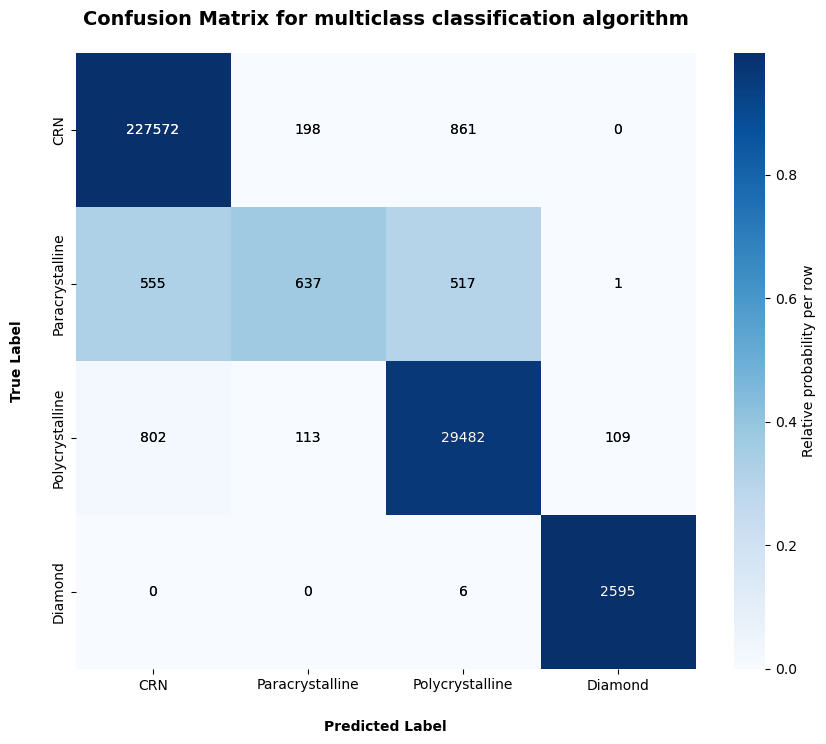

In [81]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, structure_labels, size_labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(structure_labels.numpy())
            y_pred.extend(predicted.numpy())

    cm = confusion_matrix(y_true, y_pred)

    cm_normalised=cm/cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, cmap='Blues', fmt=".0f", cbar=False, xticklabels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'], yticklabels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'])
    ax=sns.heatmap(cm_normalised, annot=False,  cmap='Blues', cbar=True,
                 cbar_kws={"label":"Relative probability per row"},
                 xticklabels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'], yticklabels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # Set text color to white if the background is dark (intensity > 0.5)
            color = "white" if cm_normalised[i, j] > 0.5 else "black"
            ax.text(j + 0.5, i + 0.5, f"{cm[i, j]:.0f}", ha="center", va="center", color=color)

    plt.title('Confusion Matrix for multiclass classification algorithm', pad=20, fontweight='bold', fontsize=14)
    plt.xlabel('Predicted Label', labelpad=20, fontweight='bold')
    plt.ylabel('True Label', labelpad=20, fontweight='bold')   
    plt.savefig('confusion_matrix_multi_label_class_exp_8.png')
    plt.show()



plot_confusion_matrix(model, test_loader)
    

### Confusion Matrix per structure size

/tmp/ipykernel_2028181/1831824416.py:36: RuntimeWarning: invalid value encountered in divide
  cm_normalised=cm/cm.sum(axis=1, keepdims=True)
/tmp/ipykernel_2028181/1831824416.py:36: RuntimeWarning: invalid value encountered in divide
  cm_normalised=cm/cm.sum(axis=1, keepdims=True)


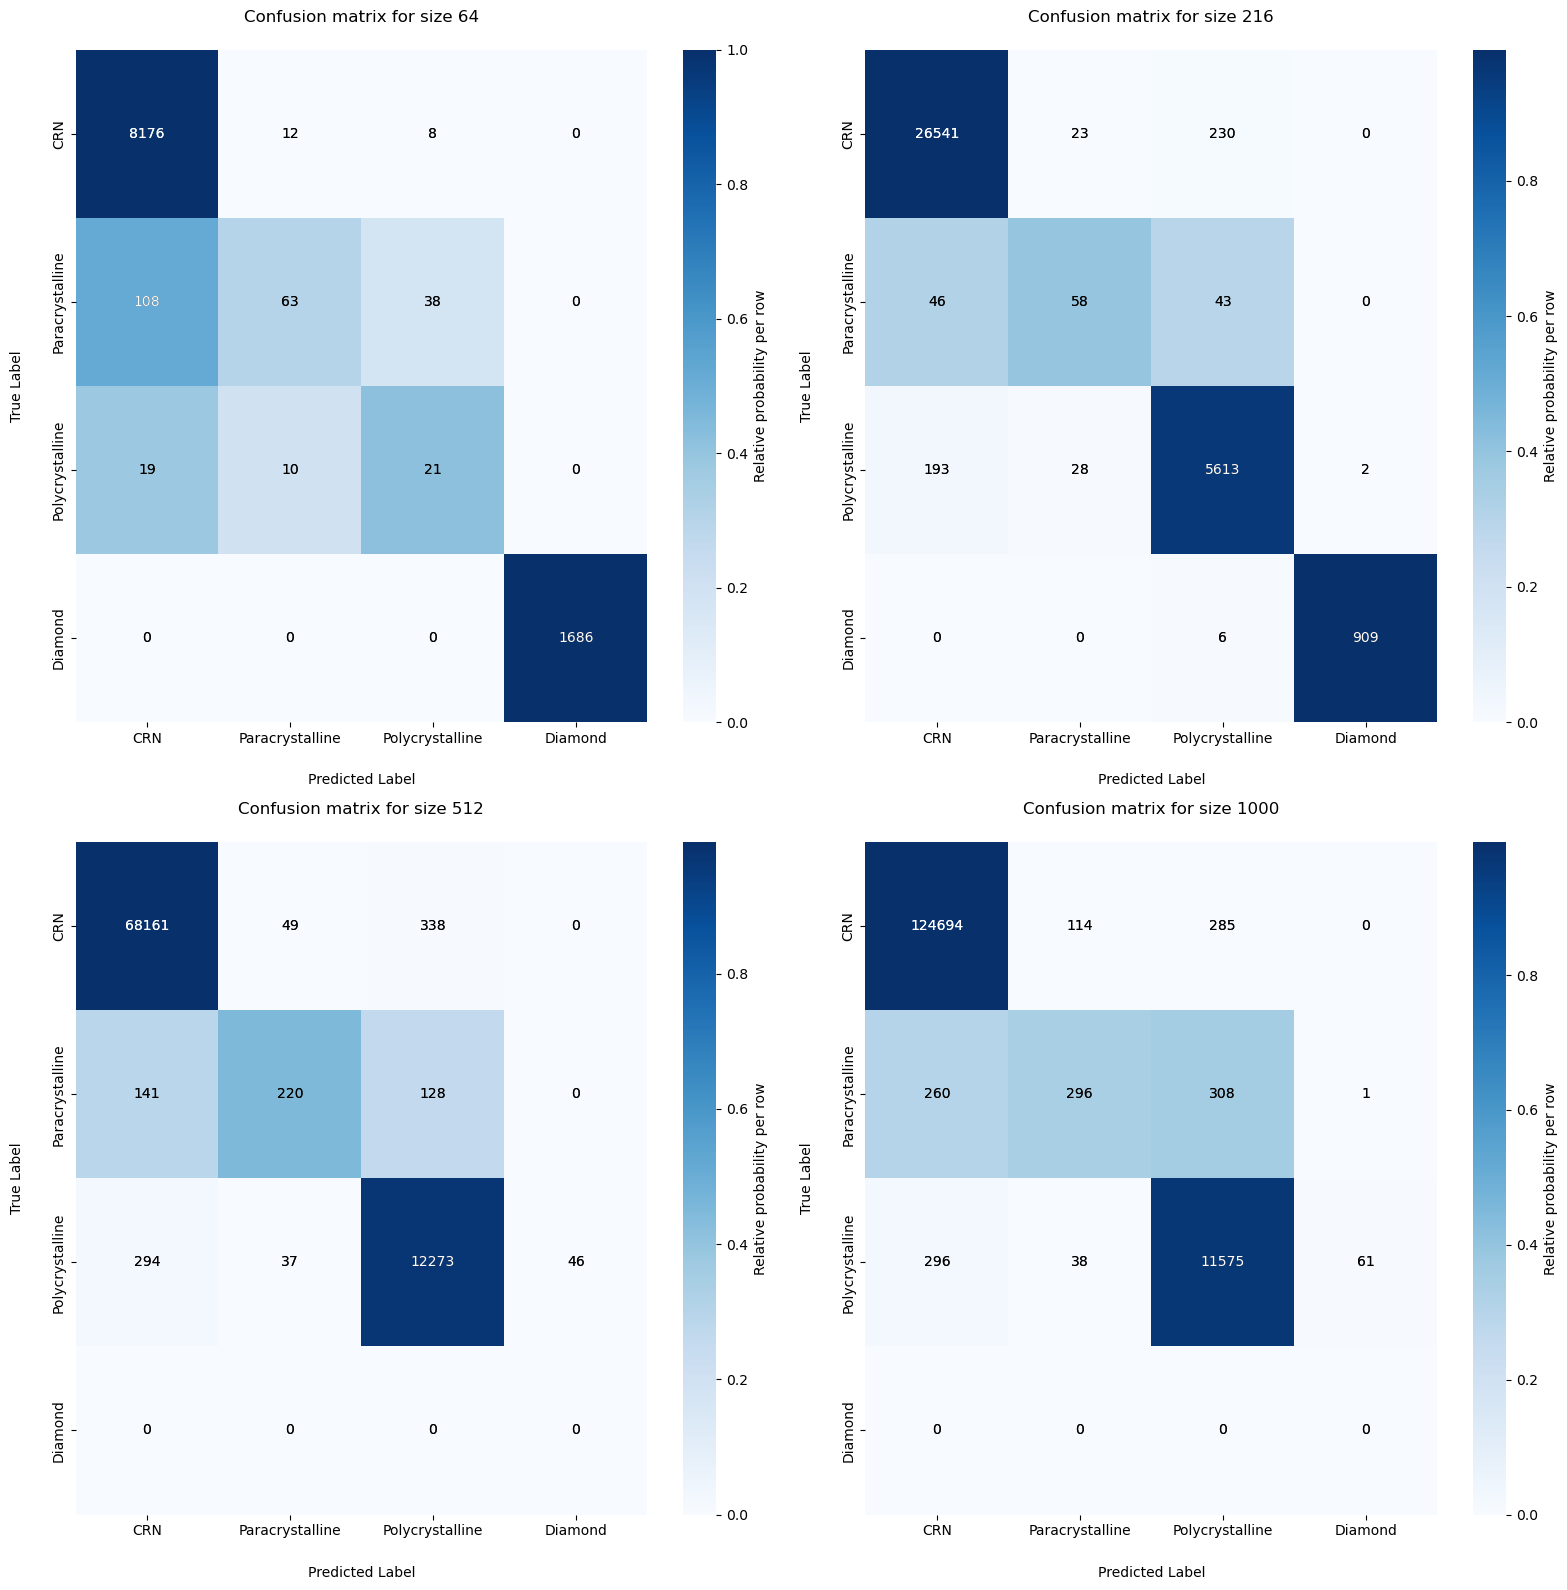

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader):
    model.eval()
    structure_true_labels = []
    size_true_labels = []
    y_pred = []


    with torch.no_grad():
        for data, structure_labels, size_labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            structure_true_labels.extend(structure_labels.numpy())
            size_true_labels.extend(size_labels.numpy())
            y_pred.extend(predicted.numpy())


    # Generate confusion matrix for different structure sizes
    structure_sizes=set(size_true_labels)
    structure_sizes = sorted(structure_sizes)

    size_dict = {64: [0,0], 216: [0,1], 512: [1,0], 1000: [1,1]}

    fig, axes = plt.subplots(2, 2, figsize=(16, 16))

    for size in structure_sizes:
        index=[i for i, x in enumerate(size_true_labels) if x == size]
        structure_true_labels_per_size=[structure_true_labels[i] for i in index]
        predicted_labels_per_size=[y_pred[i] for i in index]

        #Create a confusion matrix for the specific size
        cm = confusion_matrix(structure_true_labels_per_size, predicted_labels_per_size)

        cm_normalised=cm/cm.sum(axis=1, keepdims=True)

        # plt.figure(figsize=(10, 8))
        axes_index=size_dict[size]
        ax_i=axes[axes_index[0], axes_index[1]]

        sns.heatmap(cm, annot=True, ax=ax_i, cmap='Blues', fmt=".0f", cbar=False, xticklabels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'], yticklabels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'])
        ax=sns.heatmap(cm_normalised, annot=False,  cmap='Blues', cbar=True, ax=ax_i,
                    cbar_kws={"label":"Relative probability per row"},
                    xticklabels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'], yticklabels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'])
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                # Set text color to white if the background is dark (intensity > 0.5)
                color = "white" if cm_normalised[i, j] > 0.5 else "black"
                ax.text(j + 0.5, i + 0.5, f"{cm[i, j]:.0f}", ha="center", va="center", color=color)
        
        ax_i.set_title(f"Confusion matrix for size {size:.0f}", pad=20)
        ax_i.set_xlabel('Predicted Label', labelpad=20)
        ax_i.set_ylabel('True Label', labelpad=20)
        # plt.savefig(f'confusion_matrix_multi_label_exp_8_all_sizes.png')

    plt.tight_layout()  # Prevents overlap between plots
    plt.show()
    

plot_confusion_matrix(model, test_loader)

### Confusion matrix for each size - individual plots

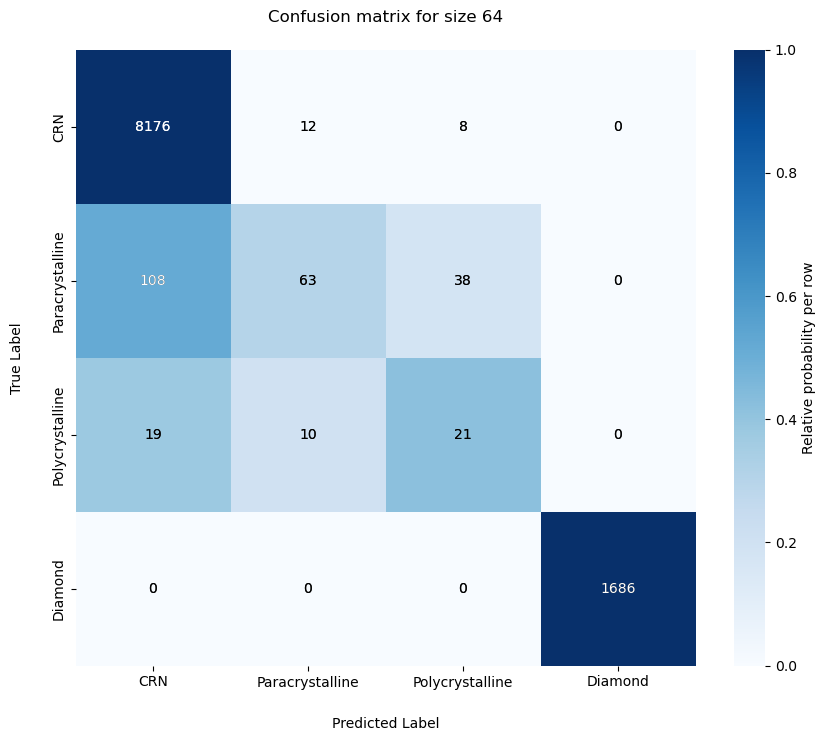

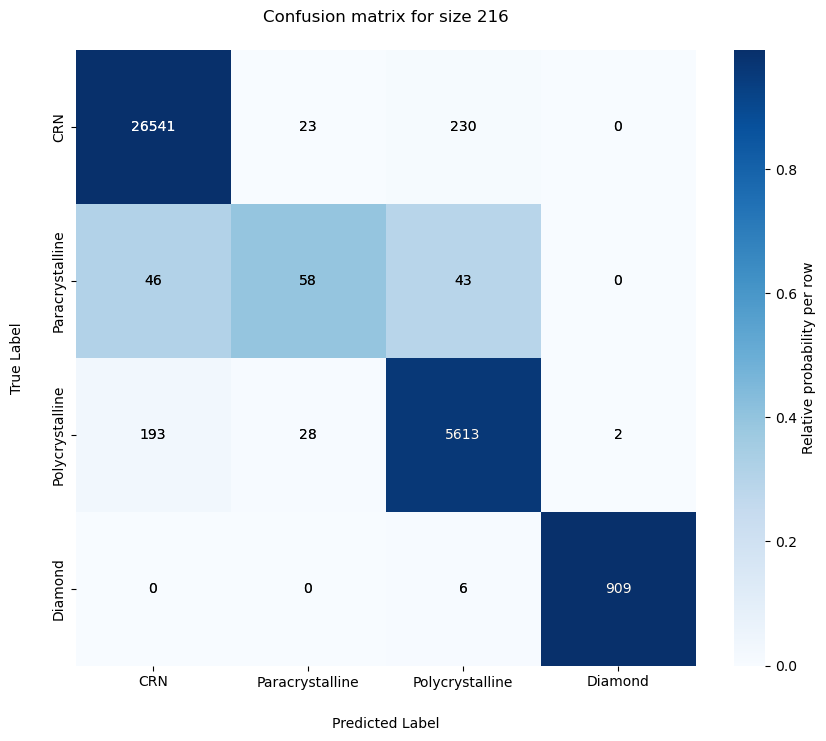

/tmp/ipykernel_2028181/2835017909.py:33: RuntimeWarning: invalid value encountered in divide
  cm_normalised=cm/cm.sum(axis=1, keepdims=True)


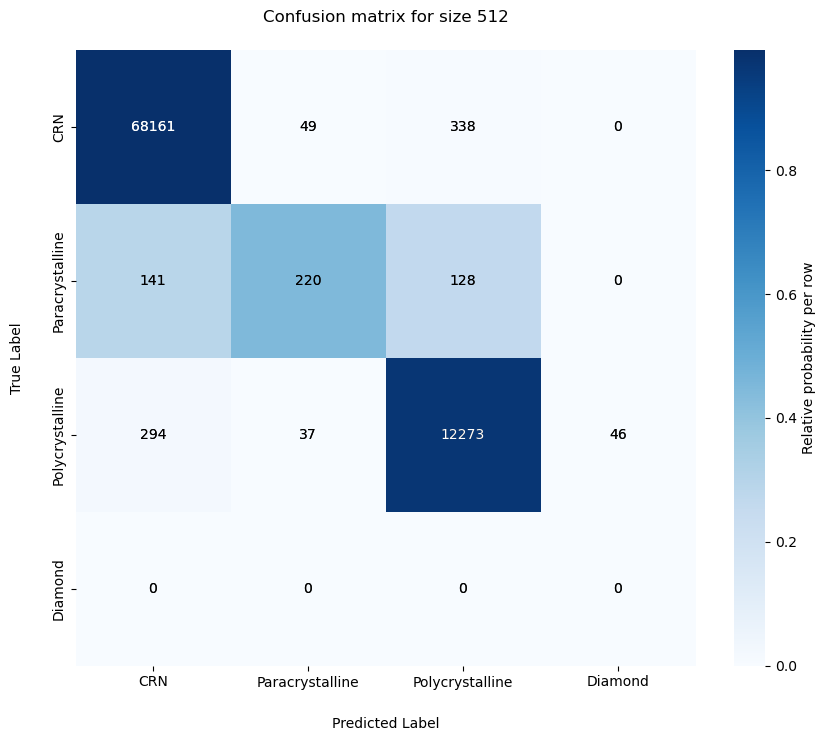

/tmp/ipykernel_2028181/2835017909.py:33: RuntimeWarning: invalid value encountered in divide
  cm_normalised=cm/cm.sum(axis=1, keepdims=True)


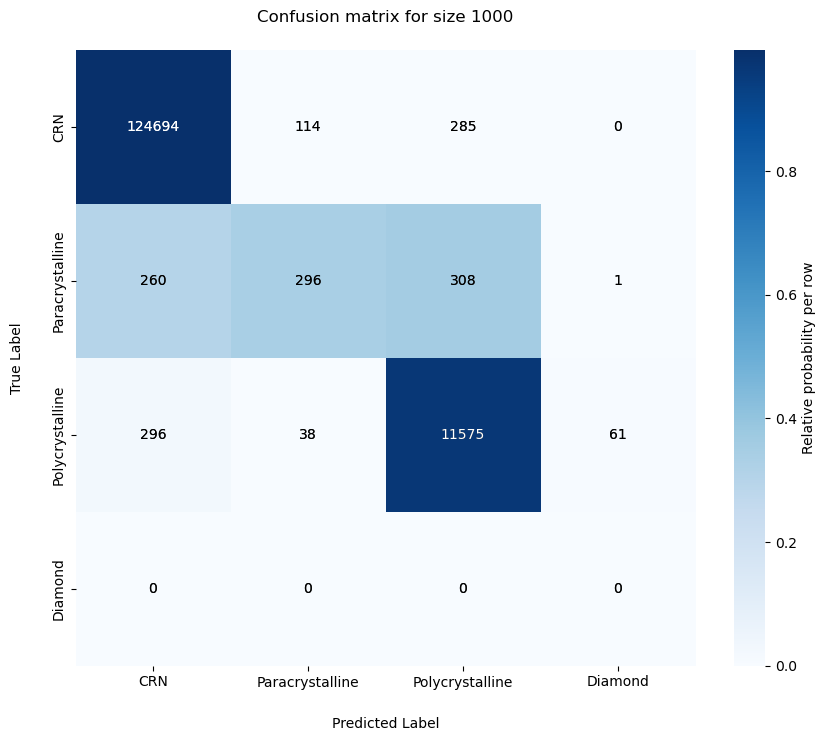

In [65]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader):
    model.eval()
    structure_true_labels = []
    size_true_labels = []
    y_pred = []


    with torch.no_grad():
        for data, structure_labels, size_labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            structure_true_labels.extend(structure_labels.numpy())
            size_true_labels.extend(size_labels.numpy())
            y_pred.extend(predicted.numpy())


    # Generate confusion matrix for different structure sizes
    structure_sizes=set(size_true_labels)
    structure_sizes = sorted(structure_sizes)


    for size in structure_sizes:
        index=[i for i, x in enumerate(size_true_labels) if x == size]
        structure_true_labels_per_size=[structure_true_labels[i] for i in index]
        predicted_labels_per_size=[y_pred[i] for i in index]

        #Create a confusion matrix for the specific size
        cm = confusion_matrix(structure_true_labels_per_size, predicted_labels_per_size)

        cm_normalised=cm/cm.sum(axis=1, keepdims=True)

        plt.figure(figsize=(10, 8))

        sns.heatmap(cm, annot=True, cmap='Blues', fmt=".0f", cbar=False, xticklabels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'], yticklabels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'])
        ax=sns.heatmap(cm_normalised, annot=False,  cmap='Blues', cbar=True,
                    cbar_kws={"label":"Relative probability per row"},
                    xticklabels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'], yticklabels=['CRN','Paracrystalline', 'Polycrystalline', 'Diamond'])
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                # Set text color to white if the background is dark (intensity > 0.5)
                color = "white" if cm_normalised[i, j] > 0.5 else "black"
                ax.text(j + 0.5, i + 0.5, f"{cm[i, j]:.0f}", ha="center", va="center", color=color)
        
        plt.title(f"Confusion matrix for size {size:.0f}", pad=20)    
        plt.xlabel('Predicted Label', labelpad=20)
        plt.ylabel('True Label', labelpad=20)
        plt.savefig(f'confusion_matrix_multi_label_exp_8_size_{size:.0f}.png')
        plt.show()

    

plot_confusion_matrix(model, test_loader)

In [26]:
from sklearn.metrics import classification_report

def print_classification_report(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, structure_labels, size_labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(structure_labels.tolist())
            y_pred.extend(predicted.tolist())
        
    print(classification_report(y_true, y_pred))

print_classification_report(model, test_loader)


    

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    228631
         1.0       0.67      0.37      0.48      1710
         2.0       0.96      0.97      0.96     30506
         3.0       0.96      1.00      0.98      2601

    accuracy                           0.99    263448
   macro avg       0.90      0.83      0.85    263448
weighted avg       0.99      0.99      0.99    263448

